In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
from scipy.misc import derivative
from scipy.integrate import quadrature

from matplotlib import animation, rc
from IPython.display import HTML
matplotlib.rcParams['animation.html'] = 'html5'
matplotlib.rcParams['figure.figsize'] = (12, 8)
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['font.size'] = 16

In [2]:
def make_fig():
    fig, ax = plt.subplots()
    plt.xlim(-.2, 6.2)
    plt.ylim(1-.2, 5.2)
    ax.set_aspect("equal")
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    return fig, ax

def next_color(ax):
    cycle = ax._get_lines.prop_cycler
    return next(cycle)["color"]

In [3]:
def plot_arrow(ax, xy, dxy, label, label_dx=0, label_dy=0, color=None, lw=1):
    if color is None:
        color = next_color(ax)

    if not isinstance(xy, np.ndarray): xy = np.array(xy)
    if not isinstance(dxy, np.ndarray): dxy = np.array(dxy)

    #ax.plot(v[:,0], v[:,1], "o", color=color)
    ax.annotate("", xy=xy + dxy, xytext=xy,
                arrowprops=dict(linewidth=lw, headwidth=10, color=color))
    ax.annotate(label, [xy[0] + .5 * dxy[0] + label_dx, xy[1] + .5*dxy[1] + label_dy], color=color, fontsize=20)

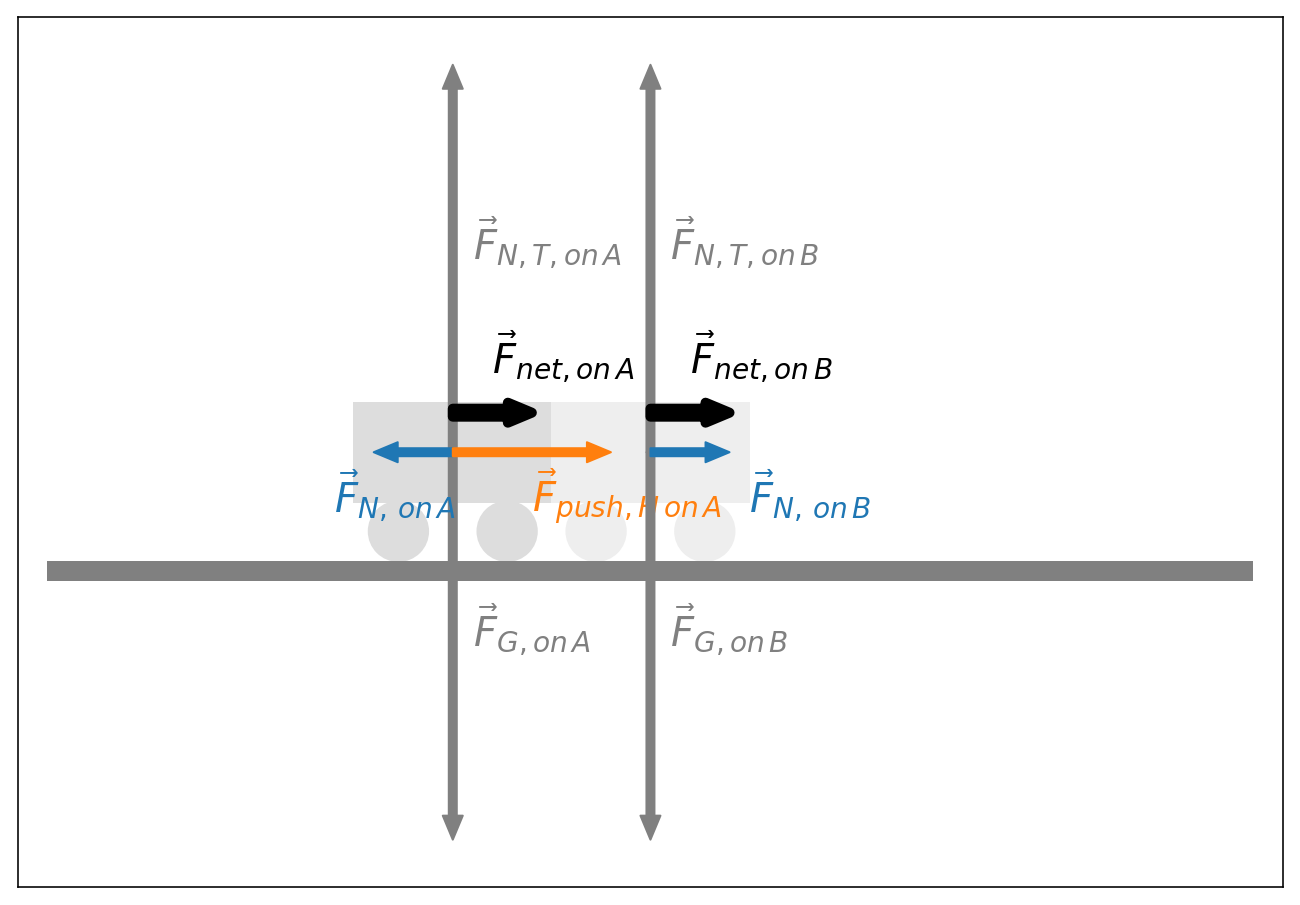

In [4]:
def plot_cart(ax, pos, ext, m, Fpush=[0, 0], FNx=[0, 0],
              color="lightgray", label="", label_alt="", yfac=.2):
    pos, ext = [np.asarray(arr) for arr in [pos, ext]]
    FG = [0, -m*9.8]
    FG, Fpush, FNx = [.1 * np.asarray(arr) for arr in [FG, Fpush, FNx]]
    FG *= yfac
    FN = - FG
    Fnet = Fpush + FG + FN + FNx
    r = .15

    plot_cart.colorv = "gray"
    plot_cart.colorg = "gray"
    if not hasattr(plot_cart, "colorv"): plot_cart.colorv = next_color(ax)
    if not hasattr(plot_cart, "colorg"): plot_cart.colorg = next_color(ax)
    if not hasattr(plot_cart, "colorn"): plot_cart.colorn = next_color(ax)
    if not hasattr(plot_cart, "colorp"): plot_cart.colorp = next_color(ax)

    cart = matplotlib.patches.Rectangle(pos - .5*ext, ext[0], ext[1], color=color)
    ax.add_patch(cart)
    w1 = matplotlib.patches.Circle([pos[0] - .5*ext[0] + 1.5*r, pos[1] - .5*ext[1]-r], r,
                                   color=color)
    ax.add_patch(w1)
    w2 = matplotlib.patches.Circle([pos[0] + .5*ext[0] - 1.5*r, pos[1] - .5*ext[1]-r], r,
                                   color=color)
    ax.add_patch(w2)
    plot_arrow(ax, pos, FG, r"$\vec F_{G, on\, %s}$" % (label), label_dx=.1, label_dy=0,
              color=plot_cart.colorg)
    plot_arrow(ax, pos, FN, r"$\vec F_{N, T, on\, %s}$" % (label), label_dx=.1, label_dy=0,
              color=plot_cart.colorv)
    if FNx[0]:
        ldx = .3
        if FNx[0] < 0:
            ldx = -.4
        plot_arrow(ax, pos, FNx, r"$\vec F_{N, %s\, on\, %s}$" % (label_alt, label), label_dx=ldx, label_dy=-.3,
                   color=plot_cart.colorn)
    if Fpush[0]:
        plot_arrow(ax, pos, Fpush, r"$\vec F_{push, H\, on\, %s}$" % (label),
                   label_dx=0, label_dy=-.3, color=plot_cart.colorp)
    plot_arrow(ax, pos + np.asarray([0, .2]), Fnet, r"$\vec F_{net,on\, %s}$" % (label),
               label_dx=0, label_dy=.2, lw=5, color="black")


def cart(filename, Fpush=(8, 0), FNx=(4, 0)):
    Fpush, FNx = [np.asarray(arr) for arr in [Fpush, FNx]]

    fig, ax = make_fig()

    #track
    ax.plot([0, 6], [2.4, 2.4], color="gray", lw=10)

    colorA = "#dddddd"
    colorB = "#eeeeee"
    FNx = np.asarray([4, 0])
    plot_cart(ax, (2, 3), (1, .5), m=10, Fpush=Fpush, FNx=-FNx, label="A", color=colorA)
    plot_cart(ax, (3, 3), (1, .5), m=10, FNx=FNx, label="B", color=colorB)

    plt.savefig(filename)

cart("carts1.pdf")

In [5]:
T = 5 # max time
n_frames = 100 # number of frames in movie (the greater, the smoother the movie)

def motion(Fpush=[8., 0], FNx=[0., 0], cartB=False, m_A=10, m_B=10, yfac=.2):
    Fpush, FNx = [np.asarray(arr) for arr in [Fpush, FNx]]
    fig, ax = make_fig()

    color = next_color(ax)

    #track
    ax.plot([0, 6], [2.4, 2.4], color="gray", lw=10)

    colorA = "#dddddd"
    colorB = "#eeeeee"
    #plot_cart(ax, (2, 3), (1, .5), Fpush=Fpush, FNx=-FNx, label="A", color=colorA)
    #plot_cart(ax, (3, 3), (1, .5), FNx=FNx, label="B", color=colorB)

    def init():
        return []

    def animate(i):
        global arrows
        t = float(i) / n_frames * T

        ax.clear()
        ax.set_xlim(-.2, 6.2)
        ax.set_ylim(1-.2, 5.2)
        ax.set_title("t = {:.02f} s".format(t))

        #track
        ax.plot([0, 6], [2.4, 2.4], color="k", lw=10)

        aA = (Fpush - FNx)[0] / m_A
        aB = (FNx)[0] / m_B
        xA = .5 * aA * t**2 + 1
        xB = .5 * aB * t**2 + 2

        plot_cart(ax, (xA, 3), (1, .5), m=m_A, Fpush=Fpush, FNx=-FNx,
                  label="A", label_alt="B", color=colorA, yfac=yfac)
        if cartB:
            plot_cart(ax, (xB, 3), (1, .5), m=m_B, FNx=FNx,
                      label="B", label_alt="A", color=colorB, yfac=yfac)

        return []

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=n_frames + 1, interval=T/n_frames*1000,
                                   blit=True, repeat=False)
    plt.close()

    return anim

In [6]:
motion(Fpush=[8, 0])

In [7]:
motion(Fpush=[8,0], cartB=True)

In [8]:
motion(cartB=True, Fpush=[8, 0], FNx=[8, 0])

In [9]:
motion(cartB=True, Fpush=[8, 0], FNx=[4, 0])

In [10]:
motion(cartB=True, Fpush=[8, 0], FNx=[4, 0], m_A=30, m_B=10, yfac=.05)

In [11]:
motion(cartB=True, Fpush=[8, 0], FNx=[2, 0], m_A=30, m_B=10, yfac=.05)